# Sentence Segmentation

## Import libraries and declare constants

In [1]:
from nltk.tokenize import sent_tokenize, word_tokenize

import matplotlib.pyplot as plt
import os
import random


data_dir_path = 'data/'

## Quick Data Analysis (Qualitatively)

Have a quick look at sample data from each dataset

In [2]:
for domain in os.listdir(data_dir_path):
    domain_dir_path = os.path.join(data_dir_path, domain)

    # look at one document from each dataset
    sample_doc = os.listdir(domain_dir_path)[0]
    sample_doc_path = os.path.join(domain_dir_path, sample_doc)

    with open(sample_doc_path) as sample_file:
        text = sample_file.read()

    sentences = sent_tokenize(text)

    # look at first 20 sentences from sample document
    for sentence in sentences[:20]:
        print(sentence)

        words = word_tokenize(sentence)

        print(f'number of words: {len(words)}')
        print('--------')

General
	When two players pick the same hero in a round, the hero is banned instead and the round restarts
	All Pick hero selection duration reduced from 25 to 20 seconds
	Wards can now always be attacked by the owning player
	Harpy Stormcrafter mana capacity reduced from 150 to 125

Items
Ring of Regen
	Health regeneration reduced from 2 to 1.75

Soul Ring
	Health regen reduced from 2.5 to 2.25

Headdress
	Health regen reduced from 2.5 to 2

Mekansm
	Health regen aura reduced from 2.5 to 2

Pipe of Insight
	Health regen aura reduced from 2.5 to 2
	Recipe cost increased from 800 to 1000

Helm of the Dominator
	Health regen aura reduced from 5 to 4.25

Ring of Tarrasque
	Health regen reduced from 4.5 to 4

Royal Jelly
	Health regen reduced from 2.5 to 2.25

Necronomicon
	Strength reduced from 10/15/20 to 6/12/18

Vladmir's Offering
	Recipe cost increased from 450 to 550

Dust of Appearance
	Cost reduced from 90 to 80

Heroes
Beastmaster
	Call of the Wild Hawk
		Call of the Wild Hawk no 

It seems that the sentence tokenizer does not know how to segment sentences if punctuations are not present. This is not so much of a problem for the SIGBOVIK papers (which have full, proper English sentences), but it is quite a problem in the r/python posts and dota 2 patch notes (especially the patch notes, where changes to the game are written in point form)

Let's see what happens if a period/full-stop is added to each line for a sample dota 2 patch notes.

In [3]:
sample_dota2_txt_path = os.path.join(data_dir_path, 'dota2/7.27d.txt')

with open(sample_dota2_txt_path) as sample_file:
    # new-line characters separate 'sentences' currently
    text = sample_file.read().replace('\n\n', '. ').replace('\n', '. ')

sentences = sent_tokenize(text)

# look at first 20 sentences from sample document
for sentence in sentences[:20]:
    print(sentence)

    words = word_tokenize(sentence)

    print(f'number of words: {len(words)}')
    print('--------')

Items.
number of words: 2
--------
Drum of Endurance.
number of words: 4
--------
All stats reduced from +6 to +4.
number of words: 8
--------
Heaven's Halberd.
number of words: 4
--------
Now has a 400 gold recipe cost.
number of words: 8
--------
Soul Ring.
number of words: 3
--------
Recipe cost reduced from 350 to 275.
number of words: 8
--------
Helm of the Dominator.
number of words: 5
--------
Minimum health reduced from 1500 to 1000.
number of words: 8
--------
Now grants +4 Armor to the dominated creep.
number of words: 9
--------
Heroes.
number of words: 2
--------
Arc Warden.
number of words: 3
--------
Tempest Double.
number of words: 3
--------
Tempest Double no longer breaks Smoke of Deceit.
number of words: 9
--------
Talents.
number of words: 2
--------
Level 10 Talent reduced from +350 Flux Cast Range to +300.
number of words: 12
--------
Bane.
number of words: 2
--------
Brain Sap.
number of words: 3
--------
Brain Sap manacost increased from 110/130/150/170 to 120/14

Now this looks more correct.

Let's try fixing sentence segmentation for r/python posts by adding periods to 'sentences' that end with new-line characters but no ending punctuation ('.', '!', '?') directly before the new-line character.

In [4]:
sample_rpython_txt_path = os.path.join(data_dir_path, 'r-python/debugging-cheat-sheet.txt')

with open(sample_rpython_txt_path) as sample_file:
    # assume there is one sentence on each line
    text = sample_file.read()

lines = text.splitlines()
for index, line in enumerate(lines):
    # empty line, or
    # already has ending punctuation mark
    if line == '' or line[-1] in ('.', '!', '?'):
        continue

    lines[index] = line + '.'

text = ' '.join(lines)

sentences = sent_tokenize(text)

# look at first 20 sentences from sample document
for sentence in sentences[:20]:
    print(sentence)

    words = word_tokenize(sentence)

    print(f'number of words: {len(words)}')
    print('--------')

 Nice.
number of words: 2
--------
Btw u forgot the worst of them all .
number of words: 9
--------
== and =.
number of words: 4
--------
[Rubber Duck Debugging](https://rubberduckdebugging.com).
number of words: 11
--------
Edit: Fixed a word.
number of words: 6
--------
Great sheet!
number of words: 3
--------
If you don't mind me asking, what did you make it with?
number of words: 15
--------
I think it would be helpful to include a reminder that a SyntaxError might be caused by a mistake on a previous line: if line 29 has a SyntaxError and nothing looks wrong, you should check line 28 or 27.
number of words: 43
--------
Thanks!
number of words: 2
--------
This should help our students who seem alergic to reading error messages before asking for help :p. The most common source of `NameError` for me is when I create variable in `if` block, but not inside `else` block and then try to access it after the whole if/else.
number of words: 57
--------
The best way to avoid this especially 

Not perfect (recognised 2 sentences as 1 in example above), but it is better than before

## Declare utility functions for preprocessing data

In [22]:
def preprocess_dota2_text(text: str) -> str:
    '''
    Preprocess dota 2 text, by replacing redundant new-lines with periods

    :params:
        text (str) - original text read from a dota 2 txt file

    :return:
        processed text (str)
    '''
    # handle empty lines first - otherwise we will get '..'
    text = text.replace('\n\n', '. ').replace('\n', '. ')
    return text.replace('..', '.')

def preprocess_rpython_text(text: str) -> str:
    '''
    Preprocess r/python text, by filling in missing periods

    :params:
        text (str) - original text read from a r/python txt file

    :return:
        processed text (str)
    '''
    lines = text.splitlines()
    for index, line in enumerate(lines):
        # empty line, or
        # already has ending punctuation mark
        if line == '' or line[-1] in ('.', '!', '?'):
            continue

        lines[index] = line + '.'

    return ' '.join(lines)

## Define mapping of domain to its corresponding preprocessing function

In [6]:
preprocessing_functions = {
    'dota2': preprocess_dota2_text,
    'r-python': preprocess_rpython_text,
    'sigbovik': None,  # no need to preprocess sigbovik data further
}

## Declare function that gets all sentences in a domain-specific dataset

In [7]:
def get_domain_sentences(domain_dir_path: str, preprocess=None) -> list:
    '''
    Get all sentences in a domain-specific dataset

    :params:
        domain_dir_path (str): path to directory that contains domain-specific data
        preprocess (function): function for preprocessing data in the given domain (default: None)

    :return:
        a list of sentences in the given domain (list)
    '''
    sentences = []

    for txt in os.listdir(domain_dir_path):
        txt_file_path = os.path.join(domain_dir_path, txt)

        with open(txt_file_path) as txt_file:
            text = txt_file.read()
        
        if preprocess is not None:
            text = preprocess(text)
        
        sentences += sent_tokenize(text)

    return sentences

## Find distribution of sentence lengths in each domain

In [8]:
def get_domain_distribution(domain_dir_path: str, preprocess=None) -> dict:
    '''
    Get the distribution of sentence length in a domain

    :params:
        domain_dir_path (str): path to directory that contains domain-specific data
        preprocess (function): function for preprocessing data in the given domain (default: None)

    :return:
        a map of sentence length, to number of sentences of such length (dict)
    '''
    sentences = get_domain_sentences(domain_dir_path, preprocess)

    distribution = {}
    for sentence in sentences:
        words = word_tokenize(sentence)

        if len(words) in distribution:
            distribution[len(words)] += 1
        else:
            distribution[len(words)] = 1

    return distribution

# sentence length distribution
# key: domain name (str)
# value: distribution (dict)
# distribution key: sentence length
# distribution value: number of sentences of such length
sent_len_dist = {}

for domain in os.listdir(data_dir_path):
    domain_dir_path = os.path.join(data_dir_path, domain)
    sent_len_dist[domain] = get_domain_distribution(
        domain_dir_path,
        preprocessing_functions[domain],
    )

for domain, distribution in sent_len_dist.items():
    print(domain, distribution)

dota2 {2: 852, 21: 13, 12: 188, 11: 211, 10: 245, 4: 153, 8: 352, 3: 595, 9: 280, 5: 31, 7: 179, 6: 103, 13: 123, 15: 72, 14: 102, 19: 14, 32: 4, 43: 1, 18: 18, 16: 29, 28: 10, 17: 23, 23: 3, 37: 1, 29: 1, 20: 8, 22: 7, 25: 2, 24: 4, 33: 1, 27: 1, 38: 1, 26: 1}
sigbovik {44: 10, 32: 39, 26: 37, 33: 20, 29: 46, 12: 69, 37: 25, 13: 85, 30: 37, 39: 17, 15: 66, 23: 63, 2: 98, 17: 61, 25: 61, 43: 17, 7: 74, 21: 61, 42: 7, 9: 74, 19: 68, 16: 69, 11: 74, 28: 51, 3: 39, 27: 49, 31: 32, 6: 98, 4: 81, 18: 73, 34: 32, 36: 27, 24: 57, 56: 2, 47: 11, 54: 10, 14: 63, 8: 68, 22: 51, 48: 4, 10: 69, 38: 15, 5: 74, 199: 1, 86: 1, 40: 17, 35: 26, 91: 2, 20: 45, 41: 14, 59: 7, 96: 1, 46: 12, 77: 2, 58: 1, 64: 3, 55: 7, 65: 1, 66: 3, 50: 5, 45: 14, 52: 2, 72: 3, 112: 1, 49: 5, 62: 2, 60: 1, 51: 8, 1: 4, 87: 1, 73: 2, 69: 1, 53: 1, 68: 2, 118: 1, 136: 1, 61: 1, 110: 1, 85: 1, 67: 2, 63: 1, 111: 1, 57: 2, 102: 1, 81: 1}
r-python {16: 79, 3: 300, 8: 227, 24: 33, 1: 101, 4: 330, 19: 63, 13: 99, 17: 85, 10: 141

## Plot bar charts for ease of comparison of distributions

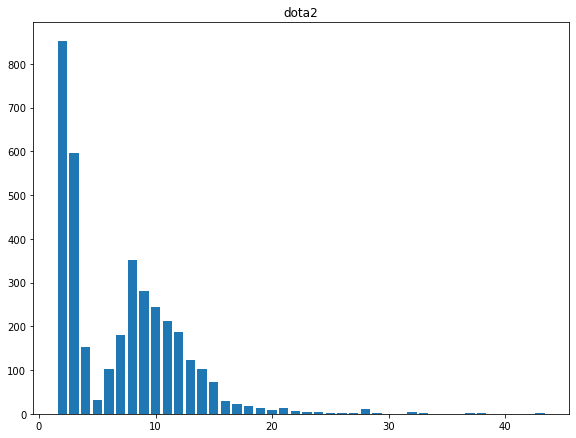

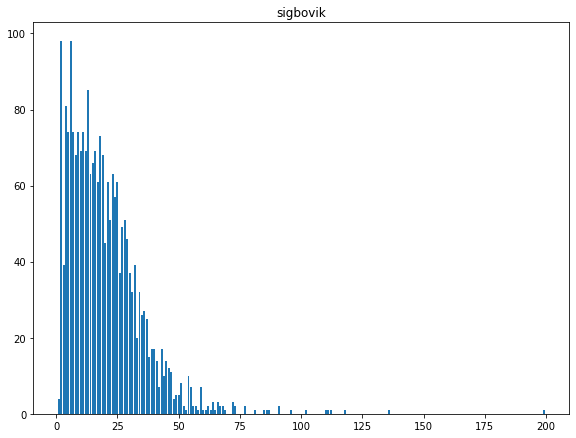

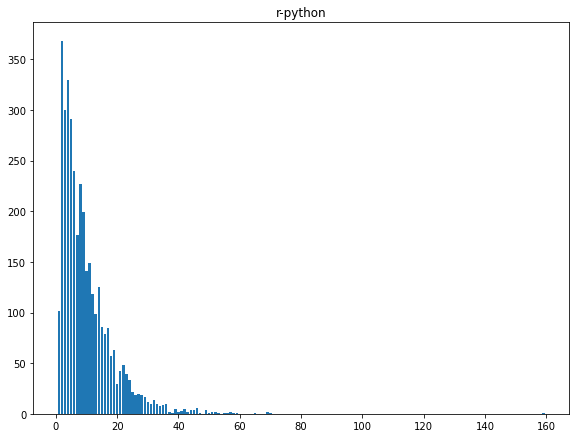

In [40]:
for domain, distribution in sent_len_dist.items():
    plt.figure(figsize=(9.6, 7.2))
    plt.bar(distribution.keys(), distribution.values())
    plt.title(domain)
    
    plt.savefig(f'output/images/{domain}_sent_len_dist.png')
    plt.show()

## Findings

### dota 2 patch notes

Dota 2 patch notes appear to have a lot of 2-words (and 3-words) sentences. I suspect these are just hero names, skill names or other headers, which should not be counted as a sentence. Also, the dip in number of words as number of words goes from 2 to 5, before rising as it approaches 9 words looks interesting. Let's check them out.

In [11]:
dota2_dir_path = os.path.join(data_dir_path, 'dota2')
sentences = get_domain_sentences(dota2_dir_path, preprocess_dota2_text)

# look at sentences that have 10 words or less to see if there is any trend
sentences_10_words_or_less = { num_words: [] for num_words in range(1, 11)}

for sentence in sentences:
    words = word_tokenize(sentence)

    if len(words) > 10:
        continue

    sentences_10_words_or_less[len(words)].append(sentence)

# check a sample for each set of sentences (sample size = 10)
for num_words, sentences in sentences_10_words_or_less.items():
    print(f'number of words: {num_words}')

    if len(sentences) < 10:
        samples = sentences
    else:
        samples = random.sample(sentences, 10)

    for sample in samples:
        print(sample)

    print('---------------------------------------------------')

number of words: 1
---------------------------------------------------
number of words: 2
Talents.
Rubick.
Talents.
Empower.
Shockwave.
Kunkka.
Broodmother.
Oracle.
Spectre.
Retaliate.
---------------------------------------------------
number of words: 3
Quelling Blade.
Treant Protector.
Sand King.
Death Prophet.
Void Spirit.
Keen Optic.
Enchant Remnant.
Homing Missile.
Rocket Flare.
Death Prophet.
---------------------------------------------------
number of words: 4
Cast Range 650.
Divided We Stand.
Yasha and Kaya.
Urn of Shadows.
Aghanim's Scepter.
Greater Faerie Fire.
Nature's Prophet.
Boots of Travel.
Drum of Endurance.
Berserker's Blood.
---------------------------------------------------
number of words: 5
Helm of the Undying.
Removed all XP talents.
Book of the Dead.
Poor Man's Shield.
Tricks of the Trade.
Keeper of the Light.
Helm of Iron Will.
Eye of the Storm.
Poor Man's Shield.
Poor Man's Shield.
---------------------------------------------------
number of words: 6
Base a

Observations:

- full stops / periods are considered one word
- apostrophes (with 's') are considered one word
- numbers separated by slashes ('/') are considered one word
- the hypothesis that two-words and three-words sentences are in fact just headers made up of hero names, skill names etc is right
- turns out 4-words phrases are mostly names as well
  - exception in sample: 'Removed all XP talents'

Let's see what the longest sentence (or one of the longest) in dota 2 patch notes looks like.

In [29]:
# utility function
def get_domain_longest_sentence(domain_dir_path: str, preprocess=None) -> list:
    '''
    Get all sentences in a domain-specific dataset

    :params:
        domain_dir_path (str): path to directory that contains domain-specific data
        preprocess (function): function for preprocessing data in the given domain (default: None)

    :return:
        the longest sentence and its length in number of words (tuple)
    '''
    sentences = get_domain_sentences(domain_dir_path, preprocess)

    longest_sentence = ''
    longest_length = 0

    for sentence in sentences:
        words = word_tokenize(sentence)

        if len(words) > longest_length:
            longest_sentence = sentence
            longest_length = len(words)

    return longest_sentence, longest_length

In [23]:
dota2_dir_path = os.path.join(data_dir_path, 'dota2')

longest_sentence, longest_length = get_domain_longest_sentence(
    dota2_dir_path,
    preprocess_dota2_text,
)

print(f'length of longest sentence: {longest_length}')
print(longest_sentence)

length of longest sentence: 37
Allows you to swallow an allied creep or hero and spit it towards enemies, stunning enemies in the area for 1.5 seconds and leaving a glob on the floor dealing 100 DPS for 3 seconds.


Interesting sentence

## SIGBOVIK papers

These papers have longer sentences and more sentences in general. However, just like with dota 2 patch notes, the number of sentences with very few words look abnormally high. We can go through the same process we did for dota 2 data set.

In [24]:
sigbovik_dir_path = os.path.join(data_dir_path, 'sigbovik')
sentences = get_domain_sentences(sigbovik_dir_path)

# look at sentences that have 10 words or less to see if there is any trend
sentences_10_words_or_less = { num_words: [] for num_words in range(1, 11)}

for sentence in sentences:
    words = word_tokenize(sentence)

    if len(words) > 10:
        continue

    sentences_10_words_or_less[len(words)].append(sentence)

# check a sample for each set of sentences (sample size = 10)
for num_words, sentences in sentences_10_words_or_less.items():
    print(f'number of words: {num_words}')

    if len(sentences) < 10:
        samples = sentences
    else:
        samples = random.sample(sentences, 10)

    for sample in samples:
        print(sample)

    print('---------------------------------------------------')

number of words: 1
.
.
.
.
---------------------------------------------------
number of words: 2
Proof.
1.
0x40-2A.
Maybe.
Preprint.
Zoolander.
wikipedia.org/wiki/DJ_Kool_Herc.
3.
2.
Please?
---------------------------------------------------
number of words: 3
Theorem 1.
Definion 2.
Future  work.
2d).
Statistical evaluation.
2).
1 tempo.
Papernot et.
Spy  check.
Rejected work.
---------------------------------------------------
number of words: 4
Knight, Eric.
Piaget, Jean.
2672–2680, 2014.
IEEE, 2018.
junyanz/CycleGAN, 2017.
Springer, 2016.
Springer, 2015.
future of humanity.
GullyNet Architecture

3.
London, 1611.
---------------------------------------------------
number of words: 5
Piaget’s theory.
[6] Selfie2Anime.
Bloomsbury publishing, 2015.
Ties are broken alphabetically.
4http://search.ancestry.com/search/db.aspx?dbid=3693
Paramount Pictures, 2004.
Please be our friend.
In ICLR,
2018.
There is no minimum.
wikipedia.org/wiki/Board_representation_(chess).
---------------------

Observations:

- it seems that some sentences have extra periods (maybe due to typo?), which are counted as sentences on their own
- looks like phrases that are misclassified as sentences are from list indices, captions and references

Check longest sentence in SIGBOVIK papers.

In [26]:
sigbovik_dir_path = os.path.join(data_dir_path, 'sigbovik')

longest_sentence, longest_length = get_domain_longest_sentence(sigbovik_dir_path)

print(f'length of longest sentence: {longest_length}')
print(longest_sentence)

length of longest sentence: 199
NUGGET samples

Sydney: 3 for $3, 6 for $6, 10 for $7.50, 20 for $12.75
Sydney CBD: 3 for $3, 6 for $5.90, 10 for $7.70, 20 for
$12.80
Melbourne: 3 for $3, 6 for $5.50, 10 for $7.20, 20 for
$12.80, 24 for $9.95
Japan: 5 for 200 yen, 15 for 570 yen
UK: 6 for 3.09, 9 for 3.99, 20 for 4.99
Thailand: 6 for 87B, 10 for 139B, 20 for 240B
Kuala Lumpur: 6 for 7.8RM, 9 for 10.9RM, 20 for 22RM
Germany: 6 for e3,59, 9 for e4,49, 20 for e7,59
Belo Horizonte: 4 for 6.50 reais, 10 for 16.40 reais
So Paulo: 4 for 6.50 reais, 10 for 13.90 reais
US (McDonalds): see Table 1
US (Burger King): see Table 2

References

Srivastava, Nitish, Hinton, Geoffrey E., Krizhevsky, Alex,
Sutskever, Ilya, and Salakhutdinov, Ruslan.


It is a misclassified sentence...

### r/python posts' comments

Let's do the same things as before.

In [28]:
rpython_dir_path = os.path.join(data_dir_path, 'r-python')
sentences = get_domain_sentences(rpython_dir_path)

# look at sentences that have 10 words or less to see if there is any trend
sentences_10_words_or_less = { num_words: [] for num_words in range(1, 11)}

for sentence in sentences:
    words = word_tokenize(sentence)

    if len(words) > 10:
        continue

    sentences_10_words_or_less[len(words)].append(sentence)

# check a sample for each set of sentences (sample size = 10)
for num_words, sentences in sentences_10_words_or_less.items():
    print(f'number of words: {num_words}')

    if len(sentences) < 10:
        samples = sentences
    else:
        samples = random.sample(sentences, 10)

    for sample in samples:
        print(sample)

    print('---------------------------------------------------')

number of words: 1
....
---------------------------------------------------
number of words: 2
Wow!
Copped !
Incredible.
Thanks.
Illustrator?
Thanks.
AWWW!
Amazing.
Congratulations!
Excellent!
---------------------------------------------------
number of words: 3
Awesome man.
Looks awesome!
Great job!
Very good!
Wow amazing.
Cyber wall?
Congrats bro!
Great job.
Cool work!
Link please.
---------------------------------------------------
number of words: 4
Damn!!!
I feel that.
Fuck!!!
That is awesome!
Good job dude!
It looks great.
This is dope!
😆 Well done.
Not just pic?
This looks amazing!
---------------------------------------------------
number of words: 5
I don't know.
Ferrari here you go.
Thats pretty cool man.
It's a sin.
So what is matplot?
Idk, well done!
Yes please, finally.
This is so cool!
That is amazing man!
That takes the biscuit.
---------------------------------------------------
number of words: 6
You tracking saccades and pursuits?
Good Job :)
A7x?
Is this the entire 

### Observations

- each punctuation (e.g. '!') is considered one word
  - emoticons like ':)' is considered two words when most humans would treat it like one (a smiley face)
- sentences with very few words are in fact legitimate sentences
  - sentences in social media tend to be short after all

Find longest sentence

In [30]:
rpython_dir_path = os.path.join(data_dir_path, 'r-python')

longest_sentence, longest_length = get_domain_longest_sentence(
    rpython_dir_path,
    preprocess_rpython_text,
)

print(f'length of longest sentence: {longest_length}')
print(longest_sentence)

length of longest sentence: 159
 For some more context this is a project I have been working on for about 2 months around full time studies, mirror display is all made using the tkinter library and each frame has its own looping function to continuously update, has date, time, weather at my location, BBC news headlines, if Leicester city football club are playing it'll display the live score in the middle, if my face is detected my uni schedule displays, if my girlfriend's face is detected it logs in to her work website and fetches and displays her work timetable, calendar event system at the bottom continuously updated and loops through upcoming events, more events can be added through voice control, music can be streamed from YouTube with voice control, will tell you the output of flipping a coin through voice control and can do calculations through voice control.


On social media, a user is under no obligation to write proper sentences so he / she can write a sentence however long he / she likes. In my opinion, this sentence should have been split up into shorter sentences.

### Let's compute some overall statistics

#### Average number of sentences per document for each domain

In [32]:
for domain in os.listdir(data_dir_path):
    domain_dir_path = os.path.join(data_dir_path, domain)
    preprocess = preprocessing_functions[domain]
    domain_num_sentences = 0

    for txt in os.listdir(domain_dir_path):
        txt_file_path = os.path.join(domain_dir_path, txt)

        with open(txt_file_path) as txt_file:
            text = txt_file.read()
        
        if preprocess is not None:
            text = preprocess(text)
        
        sentences = sent_tokenize(text)
        domain_num_sentences += len(sentences)

    average_num_sentences = domain_num_sentences / len(os.listdir(domain_dir_path))
    print(f'average number of sentences per {domain} document: {average_num_sentences:.2f}')

average number of sentences per dota2 document: 181.40
average number of sentences per sigbovik document: 109.14
average number of sentences per r-python document: 182.60


Observation:

- average number of sentences for SIGBOVIK papers is quite low compared to the other 2 data sets which is quite surprising
- it makes sense that r/python posts have a lot of comments, since making comments do not require much effort
  - my guess is that the bulk of r/python (and dota 2) sentences are very short
- average number of sentences in a dota 2 patch note is probably inflated by false positive

In [34]:
# exclude sentences with 5 'words' or less for dota 2 patch notes
domain = 'dota2'
domain_dir_path = os.path.join(data_dir_path, domain)
preprocess = preprocessing_functions[domain]
domain_num_sentences = 0

for txt in os.listdir(domain_dir_path):
    txt_file_path = os.path.join(domain_dir_path, txt)

    with open(txt_file_path) as txt_file:
        text = txt_file.read()
    
    if preprocess is not None:
        text = preprocess(text)
    
    sentences = sent_tokenize(text)

    for sentence in sentences:
        words = word_tokenize(sentence)

        if len(words) > 5:
            domain_num_sentences += 1

average_num_sentences = domain_num_sentences / len(os.listdir(domain_dir_path))
print(f'average number of sentences per {domain} document: {average_num_sentences:.2f}')

average number of sentences per dota2 document: 99.85


This number of sentences for dota 2 patch notes looks more normal.

In [37]:
# check ratio of short sentences to long sentences
sentence_length_threshold = 10  # length >= 10 -> long, otherwise -> short

for domain in os.listdir(data_dir_path):
    domain_dir_path = os.path.join(data_dir_path, domain)
    preprocess = preprocessing_functions[domain]

    domain_num_long_sentences = 0
    domain_num_short_sentences = 0

    for txt in os.listdir(domain_dir_path):
        txt_file_path = os.path.join(domain_dir_path, txt)

        with open(txt_file_path) as txt_file:
            text = txt_file.read()
        
        if preprocess is not None:
            text = preprocess(text)
        
        sentences = sent_tokenize(text)

        for sentence in sentences:
            words = word_tokenize(sentence)

            if len(words) >= sentence_length_threshold:
                domain_num_long_sentences += 1
            else:
                if domain == 'dota2' and len(words) <= 5:
                    continue

                domain_num_short_sentences += 1

    print(f'short-long sentences ratio for {domain} is {domain_num_short_sentences} : {domain_num_long_sentences}')

short-long sentences ratio for dota2 is 914 : 1083
short-long sentences ratio for sigbovik is 610 : 1682
short-long sentences ratio for r-python is 2233 : 1419


This ratio is as expected.

#### Average length of sentences (in number of words) per document for each domain

- get total length of sentences in one document
- divide by number of sentences to get average sentence length for that document
- take average of average sentence length across all documents

In [43]:
for domain in os.listdir(data_dir_path):
    domain_dir_path = os.path.join(data_dir_path, domain)
    preprocess = preprocessing_functions[domain]

    domain_sentence_length = 0

    for txt in os.listdir(domain_dir_path):
        txt_file_path = os.path.join(domain_dir_path, txt)

        with open(txt_file_path) as txt_file:
            text = txt_file.read()
        
        if preprocess is not None:
            text = preprocess(text)

        sentences = sent_tokenize(text)

        num_words = 0

        for sentence in sentences:
            words = word_tokenize(sentence)
            num_words += len(words)

        average_sentence_length = num_words / len(sentences)
        domain_sentence_length += average_sentence_length

    average_domain_sentence_length = domain_sentence_length / len(os.listdir(domain_dir_path))
    print(f'average sentence length for {domain}: {average_domain_sentence_length}')

average sentence length for dota2: 6.943348826415291
average sentence length for sigbovik: 20.139721857324634
average sentence length for r-python: 10.342453216184227


As expected, the sentences in academic papers (even if they are satirical) are quite long. Patch notes tend to get to point by listing changes in gameplay only. On social media, people usually give short comments.